<a href="https://colab.research.google.com/github/casanovaalonso/TritonTutorials/blob/main/06_triton_layer_norm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install torch
!pip install triton

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 6.1 MB/s eta 0:00:00


In [4]:
import torch

import triton
import triton.language as tl

# Layer Normalization

Layer normalization is defined by the following equations for a layer with $n$ features:

For input vector $\mathbf{x} = (x_1, x_2, ..., x_n)$:

1. Mean: $\mu = \frac{1}{n} \sum_{j=1}^n x_j$
2. Variance: $\sigma^2 = \frac{1}{n} \sum_{j=1}^n (x_j - \mu)^2$
3. Normalized values: $\hat{x}_i = \frac{x_i - \mu}{\sqrt{\sigma^2 + \epsilon}}$
4. Output: $y_i = w \cdot \hat{x}_i + b$

where $w$ and $b$ are learnable parameters, and $\epsilon$ is a small constant for numerical stability.


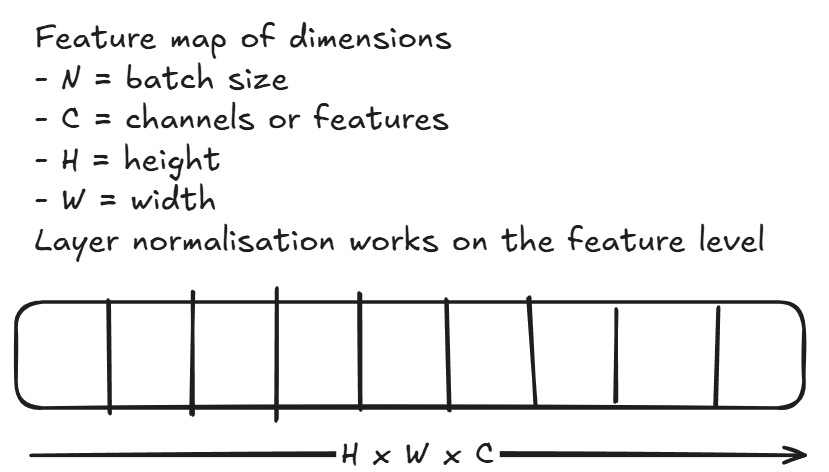

In [5]:
DEVICE = torch.device(f"cuda:{torch.cuda.current_device()}")
print(f"Device: {DEVICE}")

Device: cuda:0


In [6]:
@triton.jit
def _normalize_vector(
    input_ptr,
    output_ptr,
    n_elements,
    eps,
    BLOCK_SIZE: tl.constexpr,
):
    pid = tl.program_id(axis=0)
    block_start_ptr = input_ptr + pid * BLOCK_SIZE
    offsets = tl.arange(0, BLOCK_SIZE)
    block_ptrs = block_start_ptr + offsets
    input = tl.load(block_ptrs, mask=offsets<n_elements)
    mean = tl.sum(input, axis=0) / BLOCK_SIZE
    diff = input - mean
    variance = tl.sum(diff * diff, axis=0) / BLOCK_SIZE
    normalized = (diff) / tl.sqrt(variance + eps)
    output = normalized
    tl.store(output_ptr + pid * BLOCK_SIZE + offsets, output)

def normalize_vector(x, eps):
  output = torch.empty_like(x, device=DEVICE)
  assert x.is_contiguous() and output.is_contiguous()
  assert x.device == output.device == DEVICE
  n_elements = x.numel()
  grid = lambda meta: (triton.cdiv(x.numel(), meta['BLOCK_SIZE']),)
  _normalize_vector[grid](x, output, n_elements, eps, BLOCK_SIZE=1024)
  return output

In [7]:
x = torch.randn(1024, device=DEVICE) * 12
eps = 1e-5
output = normalize_vector(x, eps)
print(
    f"Input mean: {x.mean()}\n"
    f"Input std: {x.std()}\n"
    f"Output mean: {output.mean()}\n"
    f"Output std: {output.std()}\n"
)

Input mean: 0.2623552978038788
Input std: 12.16840648651123
Output mean: 6.984919309616089e-09
Output std: 1.0004886388778687



In [11]:
@triton.jit
def _fwd_layer_norm_kernel(
    input_ptr,
    output_ptr,
    w_ptr,
    b_ptr,
    eps,
    n_features,
    row_stride,
    BLOCK_SIZE: tl.constexpr,
):
  row = tl.program_id(axis=0)
  input_ptr = input_ptr + row * row_stride
  output_ptr = output_ptr + row * row_stride
  offsets = tl.arange(0, n_features, BLOCK_SIZE)
  mean = 0
  _mean = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
  for off in offsets:
    block_start_ptr = input_ptr + off
    block_ptrs = block_start_ptr + tl.arange(0, BLOCK_SIZE)
    mask = block_ptrs < n_features
    x = tl.load(block_ptrs, mask=mask, other=0.0).to(tl.float32)
    _mean += _mean
  mean = tl.sum(_mean, axis=0) / n_features
  _var = tl.zeros([BLOCK_SIZE], dtype=tl.float32)
  for off in offsets:
    block_start_ptr = input_ptr + off
    block_ptrs = block_start_ptr + tl.arange(0, BLOCK_SIZE)
    mask = block_ptrs < n_features
    x = tl.load(block_ptrs, mask=mask, other=0.0).to(tl.float32)
    # we are doing this to remove the mean only when we have valid indices
    x = tl.where(mask, x - mean, 0.0)
    diff = x  -mean
    _var += diff * diff
  var = tl.sum(_var, axis=0) / n_features
  sigma_2 = tl.sqrt(var + eps)
  rstd = 1 / sigma_2
  for off in offsets:
    block_start_ptr = input_ptr + off
    block_ptrs = block_start_ptr + tl.arange(0, BLOCK_SIZE)
    x = tl.load(block_ptrs, mask=mask, other=0.0).to(tl.float32)
    w_ptrs = w_ptr + off + tl.arange(0, BLOCK_SIZE)
    b_ptrs = b_ptr + off + tl.arange(0, BLOCK_SIZE)
    mask = (off + tl.arange(0, BLOCK_SIZE)) < n_features
    w = tl.load(w_ptrs, mask=mask, other=0.0)
    b = tl.load(b_ptrs, mask=mask, other=0.0)
    x_hat = rstd * (x - mean)
    y = x_hat * w + b
    tl.store(block_ptrs, x, mask=mask)

def fwd_layer_norm(
    input, w, b, eps
):
  output = torch.empty_like(input, device=DEVICE)
  assert input.is_contiguous() and output.is_contiguous()
  assert input.device == output.device == DEVICE
  stride = input.stride(0)
  n_features = input.shape[-1]
  grid = lambda meta: (triton.cdiv(input.numel(), meta['BLOCK_SIZE']),)
  _fwd_layer_norm_kernel[grid](input, output, w, b, eps, n_features, stride, BLOCK_SIZE=1024)
  return output


In [12]:
# Sample input tensor of shape (batch_size, n_features)
input_tensor = torch.randn(32, 512, device=DEVICE)  # e.g., batch_size=32, n_features=512

# Weights and biases for layer normalization
w = torch.randn(512, device=DEVICE)  # Same size as n_features
b = torch.randn(512, device=DEVICE)  # Same size as n_features

# Small epsilon to avoid division by zero during normalization
eps = 1e-5

# Apply Layer Normalization using the Triton kernel
output_tensor = fwd_layer_norm(input_tensor, w, b, eps)

# Print the output tensor
print(output_tensor)

CompilationError: at 14:12:
    output_ptr,
    w_ptr,
    b_ptr,
    eps, 
    n_features,
    row_stride,
    BLOCK_SIZE: tl.constexpr,
):
  row = tl.program_id(axis=0)
  input_ptr = input_ptr + row * row_stride
  output_ptr = output_ptr + row * row_stride
  offsets = tl.arange(0, n_features, BLOCK_SIZE)  
            ^